In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [3]:
e = 1.6 * 10 ** (-19) # charge of electron
h = 6.626 * 10 ** (-34) / (2 * np.pi) # plank constant
m_e = 9.1 * 10 ** (-31) # electron mass
m_e_ox = 1 * m_e # effective tunneling electron mass

l_1 = 1.6 * 10 ** (-10) # screening length of M1
l_2 = 1.6 * 10 ** (-10) # screening length of M2

eps_M_1 = 3 #  ionic permittivity of M1
eps_M_2 = 3 #  ionic permittivity of M2
eps_0 = 8.85 * 10 ** (-12) # dielectric constant
eps_stat = 20 # static permittivity
eps_ifl = 10 # image force lowering permittivity

A = 10 ** 6 # effective Richardson’s constant
T = 300 # temperature
k_b = 1.38 * 10 ** (-23) # boltzmann's constant

In [4]:
def Polarization(lenght, branch, scale):
    alpha = np.linspace(-np.pi/2, 3/2 * np.pi, lenght)
    b_x = 1.5
    b_y = 2.5
    a = 0.2
    m = 3
    n = 3
    theta = np.pi / 180 * 0

    delta_alpha_1 = - np.arctan((b_y * np.tan(theta) / (m * a)))

    a_hat = a / (np.cos(delta_alpha_1) ** m)
    b_x_hat = b_x + a * np.tan(delta_alpha_1) ** m

    x = a_hat * np.cos(alpha + delta_alpha_1) ** m + b_x_hat * np.sin(alpha) ** n
    y = b_y * np.sin(alpha)

    k = 1/3 * b_y/b_x

    x_tick = x + np.sin(theta) * (b_x * np.sin(theta) + b_y * np.cos(theta))*(np.sin(alpha) - np.sin(alpha) ** n) - b_x
    y_tick = y + np.sin(theta) * (b_x * np.cos(theta) - b_y * np.sin(theta))*(np.sin(alpha) - np.sin(alpha) ** n) - b_y
    y_tick -= k * x_tick
    

    x_tick_2 = x + np.sin(theta) * (b_x * np.sin(theta) + b_y * np.cos(theta))*(np.sin(alpha) - np.sin(alpha) ** n) + b_x
    y_tick_2 = y + np.sin(theta) * (b_x * np.cos(theta) - b_y * np.sin(theta))*(np.sin(alpha) - np.sin(alpha) ** n) + b_y
    y_tick_2 -= k * x_tick_2

    if branch == 'bottom':
        return [np.concatenate((x_tick[0: int(lenght/2)], x_tick_2[0: int(lenght/2)])) , np.concatenate((scale * y_tick[0: int(lenght/2)],scale * y_tick_2[0: int(lenght/2)] ))]
    elif branch == 'up':
        return [np.concatenate((x_tick[int(lenght/2)-1: -1][::-1], x_tick_2[int(lenght/2)-1: -1][::-1])), np.concatenate((scale * y_tick[int(lenght/2)-1: -1][::-1], scale * y_tick_2[int(lenght/2)-1: -1][::-1]))]
    
def hyst_sigm(points: int, k: float, c: float, shift: float, width: float, hight: float, branch: str):
    x = np.linspace(-3, 3, points)
    if branch == 'up':
        P_plus = np.array([k * x[i] + hight/(1 + np.exp(-c * (x[i] - shift)))  for i in range(points) if x[i] > 0])
        P_minus = np.array([k * x[i] + hight/(1 + np.exp(-c * (x[i] + shift + width))) - hight for i in range(points) if x[i] < 0])
        P_up = np.concatenate((P_minus, P_plus))
        return [x, P_up]
    elif branch == 'bottom':
        P_plus = np.array([k * x[i] + hight/(1 + np.exp(-c * (x[i] - shift - width)))  for i in range(points) if x[i] > 0])
        P_minus = np.array([k * x[i] + hight/(1 + np.exp(-c * (x[i] + shift))) - hight for i in range(points) if x[i] < 0])
        P_bottom = np.concatenate((P_minus, P_plus))
        return [x, P_bottom]


In [5]:
def j_DT(V, d_input, P_input, Phi_1_input, Phi_2_input):
    d = d_input * 10 ** (-9)
    P = P_input * 10 ** (-2)
    Q_s = d * P / (eps_stat * (l_1/eps_M_1 + l_2/eps_M_2) + d)
    Phi_1 = Phi_1_input * e
    Phi_2 = Phi_2_input * e
    delta_Phi_1 = l_1 * Q_s * e / (eps_0 * eps_M_1)
    delta_Phi_2 = l_2 * Q_s * e / (eps_0 * eps_M_2)
    Phi_B_1, Phi_B_2 = np.linspace(0,1, len(V)), np.linspace(0,1, len(V))
    for i in range(len(V)):
        if P[i] > 0:
            Phi_B_1[i] = Phi_1 + delta_Phi_1[i]
            Phi_B_2[i] = Phi_2 - delta_Phi_2[i]
        else:
            Phi_B_1[i] = Phi_1 - delta_Phi_1[i]
            Phi_B_2[i] = Phi_2 + delta_Phi_2[i]
    C = - 4 * e * m_e_ox / (9 * np.pi ** 2 * h ** 3)
    alpha =  4 * d * np.sqrt(2 * m_e_ox) / ( 3 * h * (Phi_B_1 + e * V - Phi_B_2))

    sihn = np.sinh(3 * e * V / 4 * alpha * (np.sqrt((Phi_B_2 - e * V / 2)) -  np.sqrt(Phi_B_1 + e * V / 2)))

    return 0.0001 * np.abs(C * np.exp(alpha * ((Phi_B_2 - e * V / 2) ** (3/2) - (Phi_B_1 + e * V / 2) ** (3/2))) / (alpha ** 2 * (np.sqrt(Phi_B_2 - e * V / 2) -  np.sqrt(Phi_B_1 + e * V / 2)) ** 2) * sihn)

In [6]:
def j_FNT(V, d_input, P_input, Phi_1_input, Phi_2_input):
    d = d_input * 10 ** (-9)
    P = P_input * 10 ** (-2)
    Q_s = d * np.abs(P) / (eps_stat * (l_1/eps_M_1 + l_2/eps_M_2) + d)
    Phi_1 = Phi_1_input * e
    Phi_2 = Phi_2_input * e
    delta_Phi_1 = l_1 * Q_s * e / (eps_0 * eps_M_1)
    delta_Phi_2 = l_2 * Q_s * e / (eps_0 * eps_M_2)
    Phi_B_1, Phi_B_2 = np.linspace(0, 1, len(V)), np.linspace(0, 1, len(V))
    for i in range(len(V)):
        if P[i] > 0:
            Phi_B_1[i] = Phi_1 + delta_Phi_1[i]
            Phi_B_2[i] = Phi_2 - delta_Phi_2[i]
        else:
            Phi_B_1[i] = Phi_1 - delta_Phi_1[i]
            Phi_B_2[i] = Phi_2 + delta_Phi_2[i]

    Phi_B = np.array([Phi_B_1[i] if V[i] < 0 else Phi_B_2[i] for i in range(len(V))])
    E_depol = - P * (1 - d / (eps_stat * (l_1/eps_M_1 + l_2/eps_M_2) + d)) / (eps_0 * eps_stat)
    E_ap = - V / d
    E_Band = (Phi_2 - Phi_1) / (e * d)
    E = np.abs(E_ap + E_Band + E_depol)
    return 0.0001 * e ** 3 * m_e * E ** 2 / (8 * np.pi * (h * 2 * np.pi) * m_e_ox * Phi_B) * np.exp(- 8 * np.pi * np.sqrt(2 * m_e_ox) * Phi_B ** (3/2) / (3 * (h * 2 * np.pi) * e * E)) 

In [7]:
def j_TI(V, d_input: float, P_input, Phi_1_input, Phi_2_input):
    d = d_input * 10 ** (-9)
    P = P_input * 10 ** (-2)
    Q_s = d * np.abs(P) / (eps_stat * (l_1/eps_M_1 + l_2/eps_M_2) + d)
    Phi_1 = Phi_1_input * e
    Phi_2 = Phi_2_input * e
    delta_Phi_1 = l_1 * Q_s * e / (eps_0 * eps_M_1)
    delta_Phi_2 = l_2 * Q_s * e / (eps_0 * eps_M_2)
    Phi_B_1, Phi_B_2 = np.linspace(0, 1, len(V)), np.linspace(0, 1, len(V))
    for i in range(len(V)):
        if P[i] > 0:
            Phi_B_1[i] = Phi_1 + delta_Phi_1[i]
            Phi_B_2[i] = Phi_2 - delta_Phi_2[i]
        else:
            Phi_B_1[i] = Phi_1 - delta_Phi_1[i]
            Phi_B_2[i] = Phi_2 + delta_Phi_2[i]

    Phi_B = np.array([Phi_B_1[i] if V[i] < 0 else Phi_B_2[i] for i in range(len(V))])
    E_depol = - P * (1 - d / (eps_stat * (l_1/eps_M_1 + l_2/eps_M_2) + d)) / (eps_0 * eps_stat)
    E_ap = - V / d
    E_Band = (Phi_2 - Phi_1) / (e * d)
    E = np.abs(E_ap + E_Band + E_depol)

    return 0.0001 * A * T ** 2 * np.array(np.exp(-1/(k_b * T) * (Phi_B - np.sqrt(e ** 3 * E / (4 * np.pi * eps_0 * eps_ifl)))))

In [8]:
def j_TI_E(d_input: float, P_input: float, Phi_1_input, Phi_2_input):
    d = d_input * 10 ** (-9)
    P = P_input * 10 ** (-2)
    Q_s = d * np.abs(P) / (eps_stat * (l_1/eps_M_1 + l_2/eps_M_2) + d)
    Phi_1 = Phi_1_input 
    Phi_2 = Phi_2_input 
    delta_Phi_1 = l_1 * Q_s / (eps_0 * eps_M_1)
    delta_Phi_2 = l_2 * Q_s / (eps_0 * eps_M_2)
    if P > 0:
        Phi_B_1 = Phi_1 + delta_Phi_1
        Phi_B_2 = Phi_2 - delta_Phi_2
    else:
        Phi_B_1 = Phi_1 - delta_Phi_1
        Phi_B_2 = Phi_2 + delta_Phi_2

    x = [0, 1, 1, 1+d_input, 1+d_input, 2+d_input]
    y = [0, 0, Phi_B_1, Phi_B_2, 0 ,0 ]
    plt.figure(figsize=[6,4])
    plt.plot(x,y)

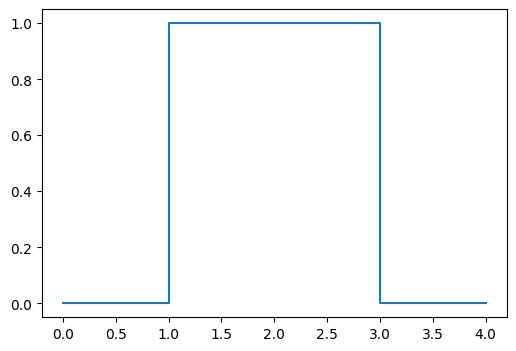

In [9]:
j_TI_E(2, 0, 1, 1)

C:\Users\Никита Жидков\AppData\Local\Temp\ipykernel_8944\3220663871.py:23: RuntimeWarning: divide by zero encountered in divide
  return 0.0001 * e ** 3 * m_e * E ** 2 / (8 * np.pi * (h * 2 * np.pi) * m_e_ox * Phi_B) * np.exp(- 8 * np.pi * np.sqrt(2 * m_e_ox) * Phi_B ** (3/2) / (3 * (h * 2 * np.pi) * e * E))


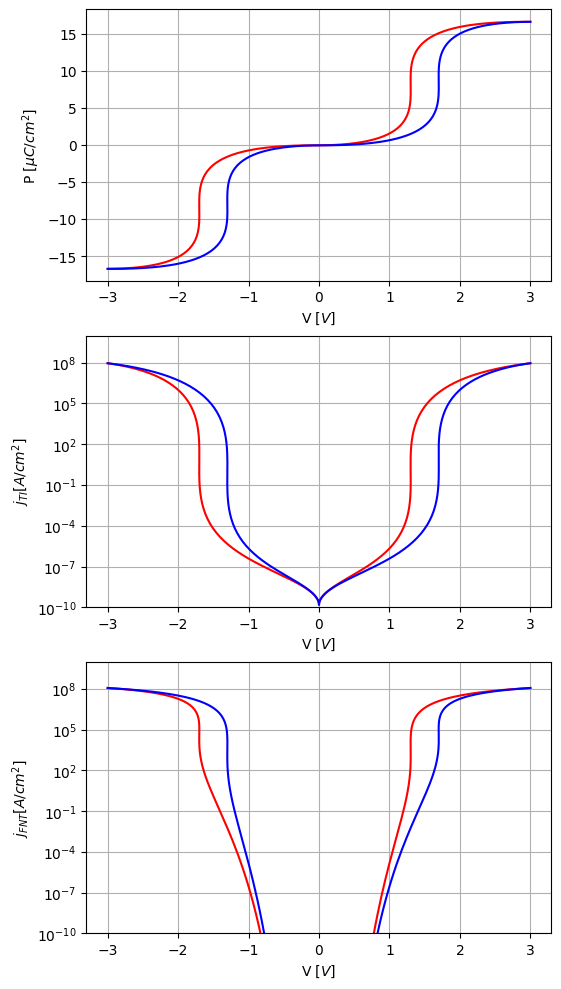

In [10]:
V_1, P_1 = Polarization(300, 'up', 5)
V_2, P_2 = Polarization(300, 'bottom', 5)

fig, ax = plt.subplots(ncols=1, nrows=3, figsize = [6,12])

ax[0].plot(V_1, P_1, 'r')
ax[0].plot(V_2, P_2, 'b')
ax[0].grid()
ax[0].set_xlabel(r'V [$V$]')
ax[0].set_ylabel(r'P $[\mu C/ cm^2]$')

ax[1].plot(V_1, j_TI(V_1, 5, P_1, 1, 1), 'r')
ax[1].plot(V_2, j_TI(V_2, 5, P_2, 1, 1), 'b')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylim([10 ** (-10), 10 ** (10)])
ax[1].set_xlabel(r'V [$V$]')
ax[1].set_ylabel(r'$j_{TI} [A/cm^2]$')

ax[2].plot(V_1, j_FNT(V_1, 5, P_1, 1, 1), 'r')
ax[2].plot(V_2, j_FNT(V_2, 5, P_2, 1, 1), 'b')
ax[2].set_yscale('log')
ax[2].grid()
ax[2].set_ylim([10 ** (-10), 10 ** (10)])
ax[2].set_xlabel(r'V [$V$]')
ax[2].set_ylabel(r'$j_{FNT} [A/cm^2]$')

plt.savefig('curr_trig.png', dpi = 300, bbox_inches = 'tight')

C:\Users\Никита Жидков\AppData\Local\Temp\ipykernel_8944\3220663871.py:23: RuntimeWarning: divide by zero encountered in divide
  return 0.0001 * e ** 3 * m_e * E ** 2 / (8 * np.pi * (h * 2 * np.pi) * m_e_ox * Phi_B) * np.exp(- 8 * np.pi * np.sqrt(2 * m_e_ox) * Phi_B ** (3/2) / (3 * (h * 2 * np.pi) * e * E))


Text(0, 0.5, '$j_{TI} + j_{FNT} [A/cm^2]$')

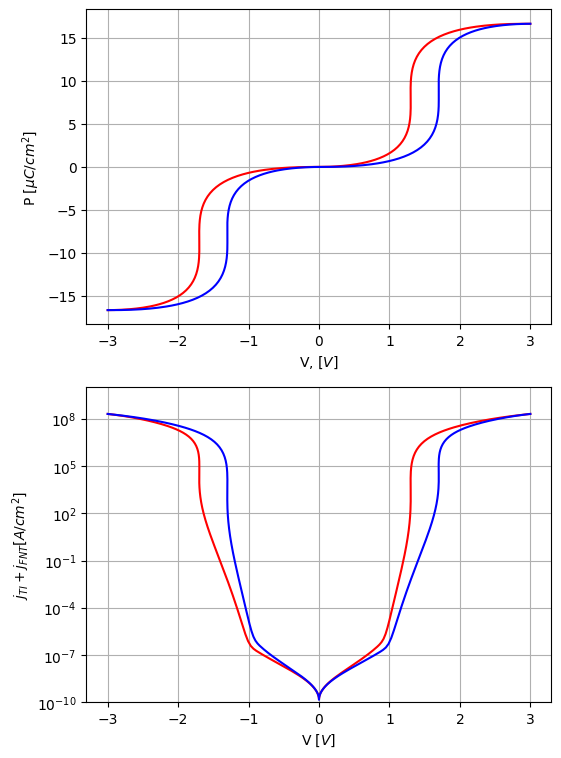

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize = [6,9])

ax[0].plot(V_1, P_1, 'r')
ax[0].plot(V_2, P_2, 'b')
ax[0].grid()
ax[0].set_xlabel(r'V, [$V$]')
ax[0].set_ylabel(r'P $[\mu C/ cm^2]$')

ax[1].plot(V_1, j_TI(V_1, 5, P_1, 1, 1) + j_FNT(V_1, 5, P_1, 1, 1), 'r')
ax[1].plot(V_2, j_TI(V_2, 5, P_2, 1, 1) + j_FNT(V_2, 5, P_2, 1, 1), 'b')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylim([10 ** (-10), 10 ** (10)])
ax[1].set_xlabel(r'V [$V$]')
ax[1].set_ylabel(r'$j_{TI} + j_{FNT} [A/cm^2]$')


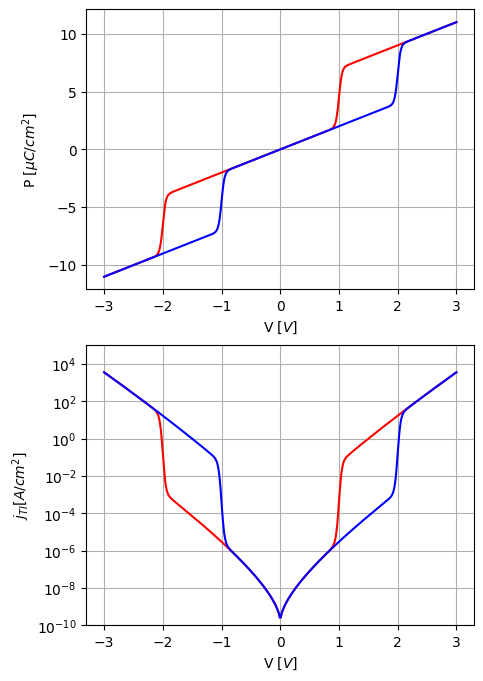

In [22]:
n = 400
V_up, P_up = hyst_sigm(n, 2, 40, 1, 1, 5, 'up')
V_bottom, P_bottom = hyst_sigm(n, 2, 40, 1, 1, 5, 'bottom')

fig, ax = plt.subplots(ncols=1, nrows=2, figsize = [5,8])

ax[0].plot(V_up, P_up, 'r')
ax[0].plot(V_bottom, P_bottom, 'b')
ax[0].grid()
ax[0].set_xlabel(r'V [$V$]')
ax[0].set_ylabel(r'P $[\mu C/ cm^2]$')

ax[1].plot(V_up, j_TI(V_up, 6, P_up, 1, 1), 'r')
ax[1].plot(V_bottom, j_TI(V_bottom, 6, P_bottom,  1, 1), 'b')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylim([10 ** (-10), 10 ** (5)])
ax[1].set_xlabel(r'V [$V$]')
ax[1].set_ylabel(r'$j_{TI} [A/cm^2]$')

'''
ax[2].plot(V_up, j_FNT(V_up, 6, P_up,  1, 1), 'r')
ax[2].plot(V_bottom, j_FNT(V_bottom, 6, P_bottom,  1, 1), 'b')
ax[2].set_yscale('log')
ax[2].grid()
ax[2].set_ylim([10 ** (-10), 10 ** (7)])
ax[2].set_xlabel(r'V [$V$]')
ax[2].set_ylabel(r'$j_{FNT} [A/cm^2]$')
'''
plt.savefig('curr_sigm.png', dpi = 300, bbox_inches = 'tight')

C:\Users\Никита Жидков\AppData\Local\Temp\ipykernel_8944\3220663871.py:23: RuntimeWarning: invalid value encountered in power
  return 0.0001 * e ** 3 * m_e * E ** 2 / (8 * np.pi * (h * 2 * np.pi) * m_e_ox * Phi_B) * np.exp(- 8 * np.pi * np.sqrt(2 * m_e_ox) * Phi_B ** (3/2) / (3 * (h * 2 * np.pi) * e * E))


Text(0, 0.5, '$j_{TI} + j_{FNT} [A/cm^2]$')

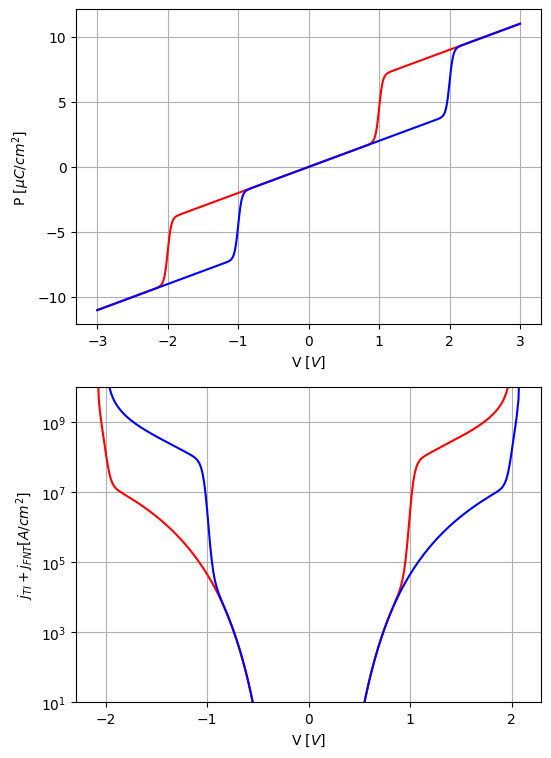

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize = [6,9])

ax[0].plot(V_up, P_up, 'r')
ax[0].plot(V_bottom, P_bottom, 'b')
ax[0].grid()
ax[0].set_xlabel(r'V [$V$]')
ax[0].set_ylabel(r'P $[\mu C/ cm^2]$')

ax[1].plot(V_up, j_FNT(V_up, 6, P_up, 0.4,0.4), 'r')
ax[1].plot(V_bottom,j_FNT(V_bottom, 6, P_bottom, 0.4,0.4), 'b')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylim([10 ** (1), 10 ** (10)])
ax[1].set_xlabel(r'V [$V$]')
ax[1].set_ylabel(r'$j_{TI} + j_{FNT} [A/cm^2]$')